<h3> Extracting protein sequences' features using ProtBert-BFD pretrained-model <h3>

<b>1. Load necessry libraries including huggingface transformers<b>

In [5]:
import torch
from transformers import AutoTokenizer, AutoModel, pipeline
import re
import numpy as np
import os
import requests
from tqdm.auto import tqdm
import pandas as pd
import skimage.measure
from sklearn.manifold import TSNE
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt

In [6]:
tqdm.pandas()

<b>2. Load the vocabulary and ProtBert-BFD Model<b>

In [7]:
tokenizer = AutoTokenizer.from_pretrained("Rostlab/prot_bert_bfd", do_lower_case=False )

In [8]:
model = AutoModel.from_pretrained("Rostlab/prot_bert_bfd")
model.init_weights()

Some weights of the model checkpoint at Rostlab/prot_bert_bfd were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


<b>3. Load the model into the GPU if avilabile<b>

In [9]:
fe = pipeline('feature-extraction', model=model, tokenizer=tokenizer,device=0 ) # device=0 for GPU, -1 for CPU

**4. Load sequences**

Files have to be loaded manually

In [10]:
FILE_KNOTTED = "SPOUT_knotted.csv"
FILE_UNKNOTTED = "Rossmann_unknotted.csv"

In [11]:
df_neg = pd.read_csv(FILE_UNKNOTTED)[["seq"]] #.sample(n=1000)
df_neg["label"] = 0

df_pos = pd.read_csv(FILE_KNOTTED, sep=';')[["seq"]] #.sample(n=1000)
df_pos["label"] = 1
df_pos

df_merged = pd.concat([df_neg, df_pos], ignore_index=True, sort=False)
# df_merged = df_merged[df_merged['seq'].str.len() < 500]


In [12]:
df_merged['seq'] = df_merged['seq'].apply(lambda sequence: " ".join(re.sub(r"[UZOB]", "X", sequence)))
print(df_merged.head())
print(df_merged.shape)

                                                 seq  label
0  M S V S M R D M L A A G V H F G H Q T R F W N ...      0
1  M A G S E T M E R T V V W F R R D L R I D D N ...      0
2  M E I L S P S P P P S H C P L L R C G G H W E ...      0
3  M I R S V V R S G R T V G R R S S R R L I S Q ...      0
4  M T V A K G E M C S V N D C R F D D N D D E I ...      0
(248444, 2)


<b>5. Extracting sequences' features <b>

In [15]:
def get_embedding(seq):
    embedding = fe(seq)
    features =  np.array(embedding[0][1:len(seq)+1])
    features = skimage.measure.block_reduce(features, (1024, 1), np.average)
    file = open("embedding_features_rand_tmp.csv", 'a')
    file.write(','.join(str(e) for e in features[0]))
    file.write('\n')
    return np.array(features[0], dtype=float)

In [ ]:
df_merged['features'] = df_merged['seq'].progress_apply(get_embedding)

 46%|████▌     | 114760/248444 [1:43:59<1:25:48, 25.97it/s] 

In [17]:
df_merged['features'].head(n=10)
#to_print = pd.DataFrame(df_merged["features"].tolist()).add_prefix("f")
#to_print['seq'] = df_merged['seq']
#to_print['label'] = df_merged['label']
#to_print.to_csv("embedding_features_randomized.csv")

0    [-1.4459752560360357, 0.44408983319135586, -0....
1    [-0.9926769671146758, 0.22993213676272717, -0....
2    [-1.4312187080504373, 0.33816158423746856, -0....
3    [-1.4707263264572248, 0.23228391646671298, -0....
4    [-1.4592209302354604, 0.3594178008539757, -0.8...
5    [-1.4442994883283973, 0.44677053420127777, -0....
6    [-1.3774306043051183, 0.47778100328673645, -0....
7    [-0.492306106723845, 0.14118144123858656, -0.3...
8    [-0.5115548447356559, 0.1156192835951515, -0.3...
9    [-1.48166018264601, 0.3728111863011634, -0.792...
Name: features, dtype: object

**6. Create the visualizatiom**

In [18]:
tsne = TSNE(n_components=2, verbose=1, random_state=123)
z = tsne.fit_transform(np.array(df_merged['features'].to_list()))
df = pd.DataFrame()
df["y"] = df_merged['label']
df["comp-1"] = z[:,0]
df["comp-2"] = z[:,1]

/home/jovyan/my-conda-envs/knots_ML/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/jovyan/my-conda-envs/knots_ML/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 248444 samples in 0.105s...
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
[t-SNE] KL divergence after 50 iterations with early exaggeration: 134.032440
[t-SNE] KL divergence after 1000 iterations: 4.510251


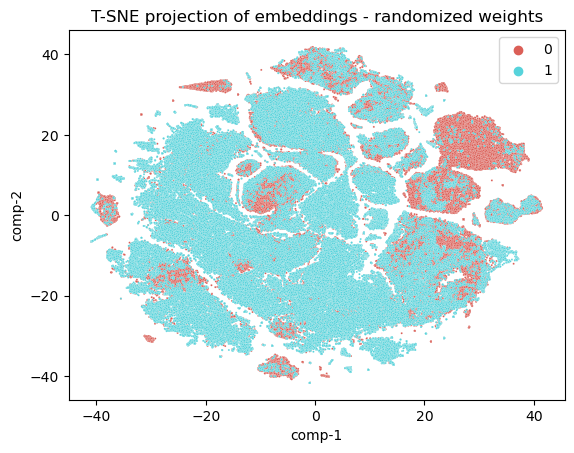

In [19]:
sns.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(),
                palette=sns.color_palette("hls", 2),
                data=df, s=2).set(title="T-SNE projection of embeddings - randomized weights")
plt.savefig("tsne_randomized.png", dpi=300)



---



---

